In [1]:
from lib.eval import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [2]:
log_dir = "/data/kai/climate_neural_processes/src/SF_Attn/logs/sfattn_train_seed0_lr0.000139_bs_1_Thu May 25 17:44:42 2023"
evaluator = Evaluator(log_dir)

NotADirectoryError: [Errno 20] Not a directory: '/data/kai/climate_neural_processes/src/SF_Attn/logs/sfattn_train_seed0_lr0.000139_bs_1_Thu May 25 17:44:42 2023/best.pt/saved_config.yaml'

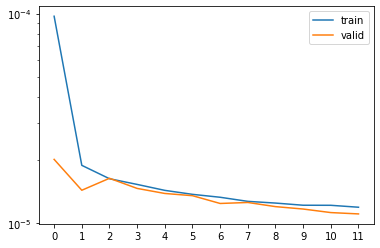

In [3]:
train_values, valid_values = evaluator.get_loss()
plt.plot(train_values, label="train")
plt.plot(valid_values, label="valid")
plt.xticks(np.arange(len(valid_values)))
plt.yscale("log")
plt.legend()
plt.show()

In [1]:
non_mae, nmae, r = evaluator.get_metrics(evaluator.testloader)
r = r**2

NameError: name 'evaluator' is not defined

In [5]:
np.save("../../notebooks/metrics/MAE_SFANP.npy", non_mae)
np.save("../../notebooks/metrics/r2_SFANP.npy", r)
np.save("../../notebooks/metrics/NMAE_SFANP.npy", nmae)
# np.save("../../notebooks/metrics/train_MAE_SFANP.npy", train_values)
# np.save("../../notebooks/metrics/valid_MAE_SFANP.npy", valid_values)

In [9]:
# Make prediction on every value including context
day, hour, idx = 5, 10, 2

In [6]:
non_y, non_y_pred, context_idxs, target_idxs = evaluator.plot_scenario(day=day, hour=hour, split="test")

non_mae = mae_metric(non_y_pred, non_y, mean=True)
R_scores = []
vars = np.arange(26)
for i in vars:
    R_scores.append(r2_score(non_y[:, i], non_y_pred[:, i]))
norm_mae = non_mae / np.abs(non_y).max(0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(vars, R_scores)
axs[0].set_title("R Scores")
axs[1].bar(vars, non_mae)
axs[1].set_title("MAE Scores")
axs[2].bar(vars, norm_mae)
axs[2].set_title("Norm-MAE Scores")
plt.suptitle("For each  26 variables")
plt.savefig(f"../../notebooks/plots/sfanp_test_metrics_{day}D_{hour}H.jpg")
plt.show()

fig, axs= plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(non_y.flatten(), bins=100)
axs[0].set_title("Ground Truth")
axs[1].hist(non_y_pred.flatten(), bins=100)
axs[1].set_title("Predicted")
plt.suptitle("Histogram of 26 variables")
plt.savefig(f"../../notebooks/plots/sfanp_test_hist_{day}D_{hour}H.jpg")
plt.show()


non_y_img = non_y.reshape(96, 144, -1)[:, :, idx]
vmin = non_y_img.min()
vmax = non_y_img.max()

contexts = np.zeros_like(non_y)
contexts[context_idxs] = non_y[context_idxs]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.set_cmap("inferno")

axs[0].imshow(contexts.reshape(96, 144, -1)[:, :, idx], vmin=vmin, vmax=vmax)
axs[0].set_title("Context Y")
axs[1].imshow(non_y_img, vmin=vmin, vmax=vmax)
axs[1].set_title("Truth Y")
pred_img = axs[2].imshow(non_y_pred.reshape(96, 144, -1)[:, :, idx], vmin=vmin, vmax=vmax)
axs[2].set_title("Predicted Y")
fig.colorbar(pred_img, ax=axs[2])

plt.suptitle(f"NORM-MAE: {norm_mae.mean():.4f}")
plt.savefig(f"../../notebooks/plots/sfanp_test_{day}D_{hour}H_{idx}V.jpg")
plt.show()

NameError: name 'day' is not defined

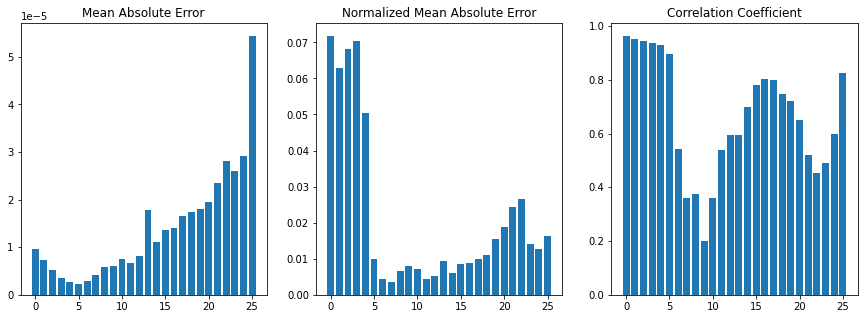

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(np.arange(26), non_mae)
axs[0].set_title("Mean Absolute Error")
axs[1].bar(np.arange(26), nmae)
axs[1].set_title("Normalized Mean Absolute Error")
axs[2].bar(np.arange(26), r)
axs[2].set_title("Correlation Coefficient")
plt.savefig("../../notebooks/plots/sfAnp_test_metrics.jpg")
plt.show()

In [11]:
# Convert to VTK

In [13]:
import vtk
import numpy as np
import os, sys, glob, dill
from tqdm import trange
import vtk.util.numpy_support as numpy_support

def array_to_vtk(array, filename):
    # Convert the NumPy array to a vtkImageData object
    image = vtk.vtkImageData()
    image.AllocateScalars(vtk.VTK_FLOAT, 1)

    vtk_data = numpy_support.numpy_to_vtk(num_array=array.flatten(), deep=True, array_type=vtk.VTK_FLOAT)
   
    image.GetPointData().SetScalars(vtk_data)
    image.SetDimensions(array.shape[::-1])

    # Write the vtkImageData object to a VTK file
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(f"{filename}.vti")
    writer.SetInputData(image)
    writer.Write()

day, hour = 5, 10
non_y, non_y_pred, context_idxs, target_idxs = evaluator.plot_scenario(day=day, hour=hour, split="test")
non_y = non_y.reshape(96, 144, -1)
non_y_pred = non_y_pred.reshape(96, 144, -1)
space = np.zeros((96, 20, 26))

array_to_vtk(np.concatenate((non_y, space, non_y_pred), axis=1), f'/home/mkim/Nserver/climate_processes/paraview/data/SFANP_y&pred_{day}D_{hour}H')